# Regression and Other Stories: Elections Economy

*Note*: This code in this notebook follows the book order of presentation

In [23]:
import arviz as az
from bambi import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf

In [25]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import seaborn as sns

*Insert Graphing the Bread and Peace Model*

In [24]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat"
hibbs = pd.read_csv(data, delimiter=" ")
hibbs

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon
5,1972,3.62,61.79,Nixon,McGovern
6,1976,1.08,48.95,Ford,Carter
7,1980,-0.39,44.70,Carter,Reagan
8,1984,3.86,59.17,Reagan,Mondale
9,1988,2.27,53.94,"Bush, Sr.",Dukakis


### Graphing the bread and peace model

In [3]:
# TODO

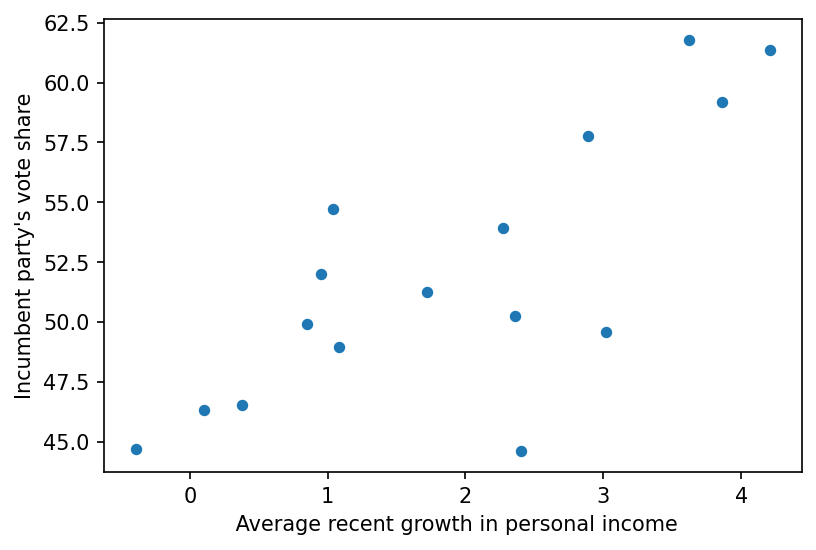

In [26]:
# TODO: Change the plot from points to years
fig, ax = plt.subplots()
hibbs.plot(kind="scatter", x="growth", y="vote", ax=ax)
ax.set_xlabel(" Average recent growth in personal income")
ax.set_ylabel("Incumbent party's vote share");

### Linear regression

In [27]:
model = Model(hibbs)
M1 = model.fit('vote ~ growth', samples=1000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vote_sd, growth, Intercept]
INFO:pymc3:NUTS: [vote_sd, growth, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7137896662672273, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
/home/tommy/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from

In [28]:
func_dict = {"Median": np.median,
            "MAD_SD":stats.median_abs_deviation,
             }
coefs = az.summary(M1, stat_funcs=func_dict, extend=False, round_to=2)
coefs

,Median,MAD_SD
Intercept[0],47.12,1.15
growth[0],2.66,0.47
vote_sd,3.96,0.50


{'Intercept': {'mu': array([52.055]), 'sd': array([6.92724149])},
 'growth': {'mu': array([0]), 'sd': array([2.14242967])}}

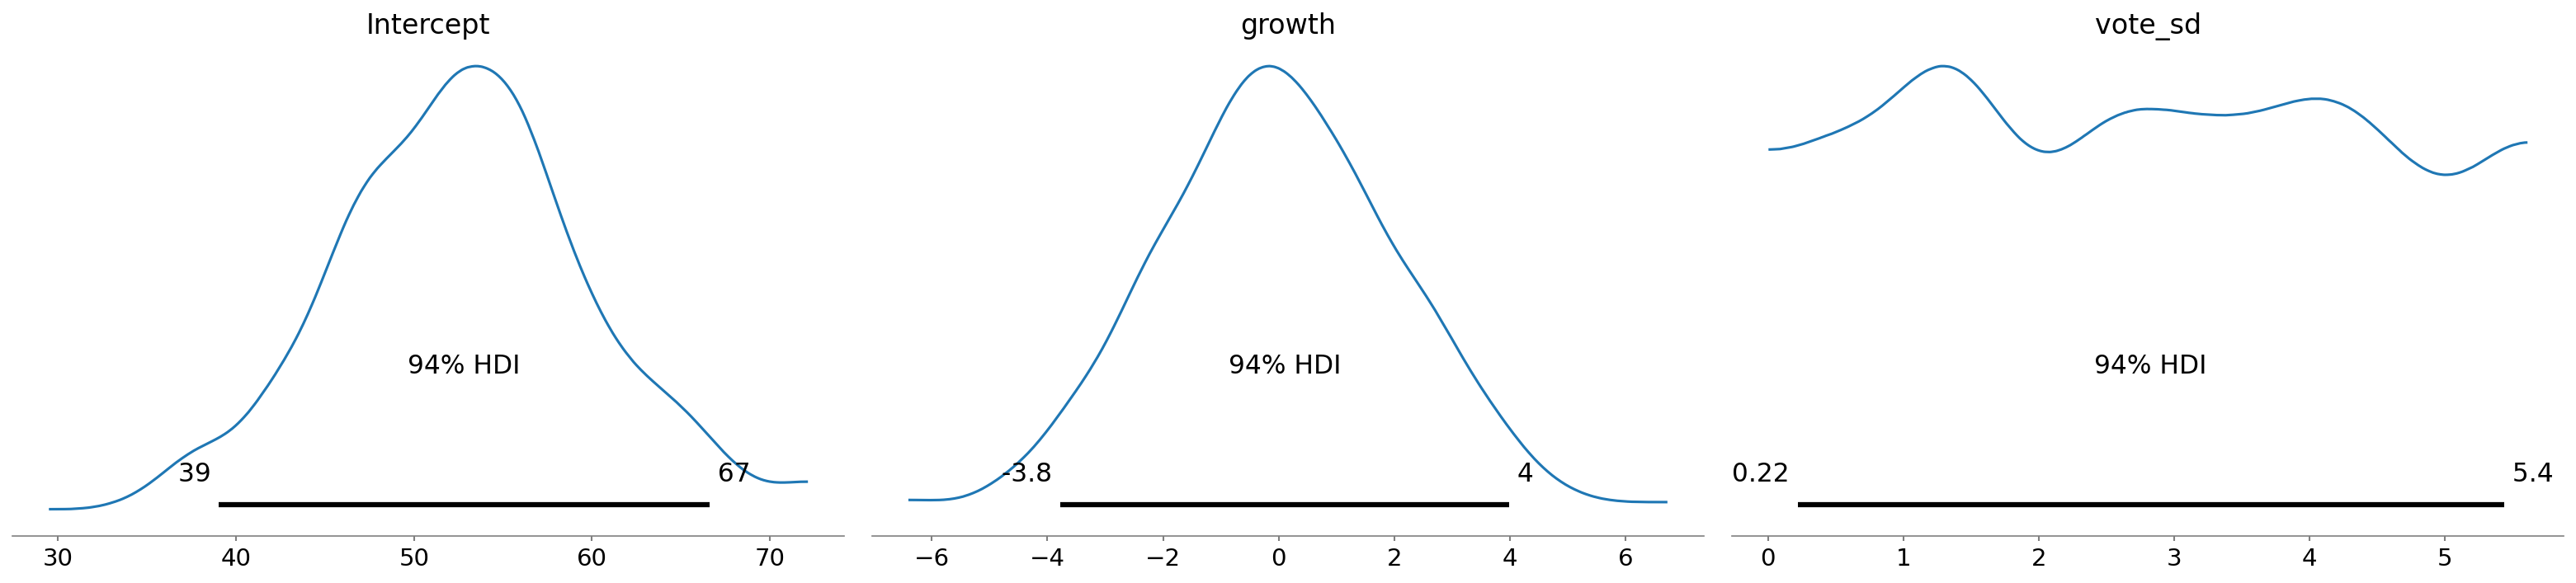

In [217]:
# 1000 draws from the priors plotted here
model.plot();
{x.name:x.prior.args for x in model.terms.values()}

#  Try and get the Prior Predictive Checks Working

In [51]:
print(dir(model))
# print(dir(pm_model))
pm_model

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add', '_add_y', '_added_priors', '_backend_name', '_diagnostics', '_match_derived_terms', '_prepare_prior', '_set_backend', '_set_priors', 'add', 'added_terms', 'auto_scale', 'backend', 'build', 'built', 'clean_data', 'completes', 'data', 'default_priors', 'dm_statistics', 'dropna', 'family', 'fit', 'fixed_terms', 'noncentered', 'plot', 'plot_priors', 'random_terms', 'reset', 'set_priors', 'taylor', 'term_names', 'terms', 'y']


In [55]:
# TODO Add prior_summary()
import pymc3 as pm
import patsy 

pm_model = model.backend.model

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

# pm.sample_prior_predictive(samples=500, model=pm_model)

In [206]:
{x.name:x.prior.args for x in model.terms.values()}
# print(dir(pm_model))
# [d for d in dir(pm_model) if "var" in d]

{'Intercept': {'mu': array([52.055]), 'sd': array([6.92724149])},
 'growth': {'mu': array([0]), 'sd': array([2.14242967])}}

In [211]:
hibbs["vote"].mean()
# hibbs["vote"].std()
# hibbs["growth"].mean()

52.055

In [97]:
y, X = patsy.dmatrices('standardize(vote) ~ 0 + standardize(growth)', data={"vote": hibbs["vote"], "growth": hibbs["growth"]})
X = np.array(X.view().squeeze())
y = np.array(y.view().squeeze())

type(X)

numpy.ndarray

In [214]:
RANDOM_SEED = 1
# Default Priors: https://arxiv.org/abs/1702.01201

with pm.Model() as pm_model_1:
    a = pm.Normal("Intercept", hibbs["vote"].mean(), 6.9)
    b = pm.Normal("growth", 0.0, 2.142)

    mu = a + b * X.mean()
    sd = pm.Uniform("vote_sd", 0, 5.60895)

    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=y.mean())
    prior_checks = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)
    
    prior_predictive = az.from_pymc3(prior=prior_checks).prior
prior_df = prior_predictive.sel(chain=0).to_dataframe()

In [215]:
display(pm_model)
display(pm_model_1)

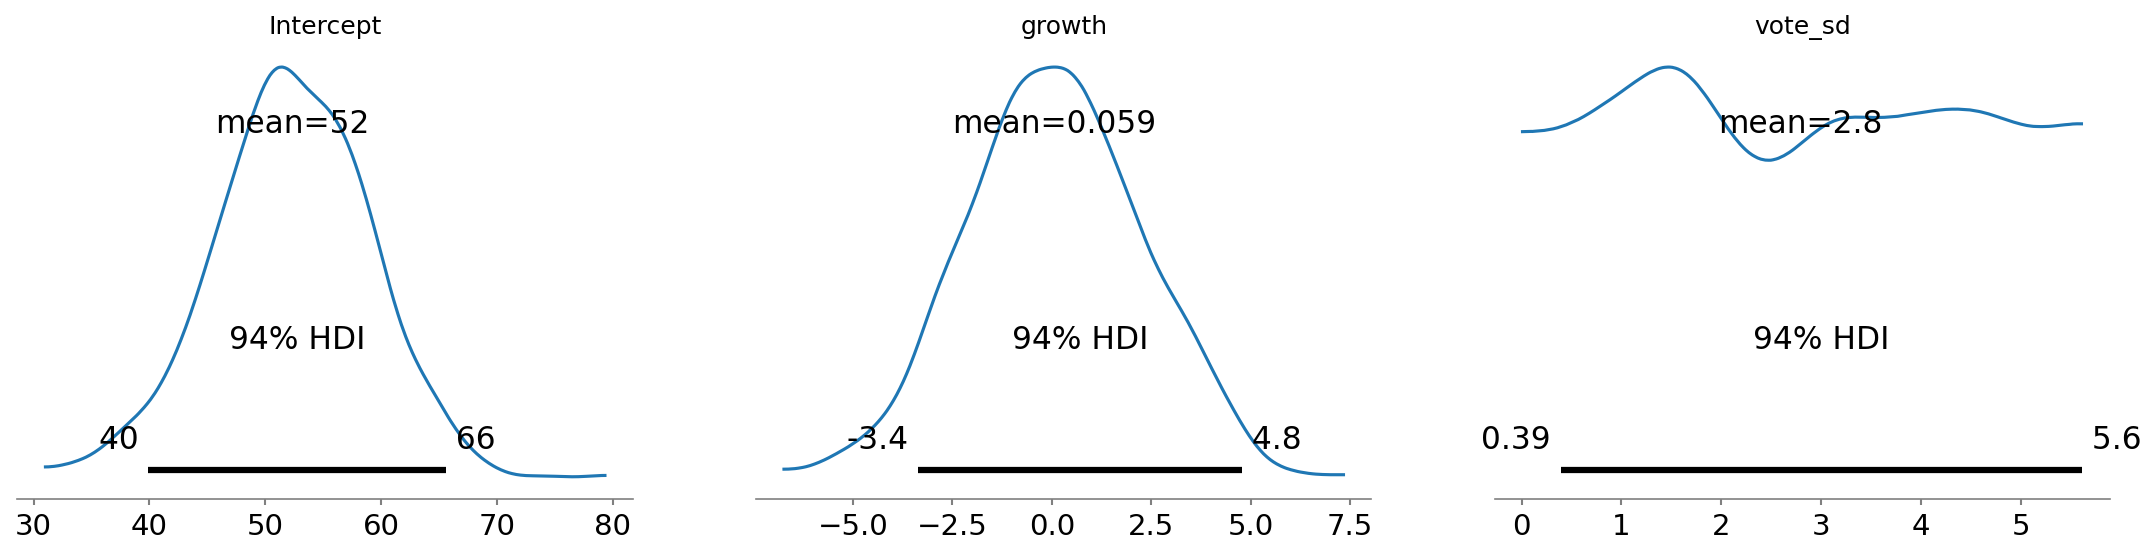

In [216]:
# PRIOR PREDICTIVE PLOTS
f, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for ix, var in enumerate(["Intercept", "growth", "vote_sd"]):
    ax = axs[ix]
    az.plot_posterior(prior_df[var].values, ax=ax)
    ax.set_title(var)

In [8]:
# TODO Add more details summary()

### Posterior interval
In Bambi and ArviZ the summary method gives us the posterior interval as well as many of the diagnostics

In [218]:
az.summary(M1, round_to=1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],47.2,1.7,44.1,50.7,0.1,0.0,949.7,945.2,955.7,1349.9,1.0
growth[0],2.6,0.7,1.3,4.1,0.0,0.0,959.0,959.0,974.5,1253.1,1.0
vote_sd,4.0,0.7,3.0,5.5,0.0,0.0,1080.2,965.1,1166.6,845.5,1.0


### Bonus: Show ordinary least squares regression

In [183]:
results = smf.ols('vote ~ growth', data=hibbs).fit()
results.summary()

/home/tommy/miniconda3/envs/stan/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vote   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     19.32
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           0.000610
Time:                        15:05:09   Log-Likelihood:                -42.839
No. Observations:                  16   AIC:                             89.68
Df Residuals:                      14   BIC:                             91.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.2476      1.622     28.514      0.000      42.769      49.726
growth         3.0605      0.696      4.396      0.001       1.567       4.554
==============================================================================
Omnibus:                        5.392   Durbin-Watson:                   2.379
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                2.828
Skew:                          -0.961   Prob(JB):                        0.243
Kurtosis:                       3.738   Cond. No.                         4.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plot Regression Line


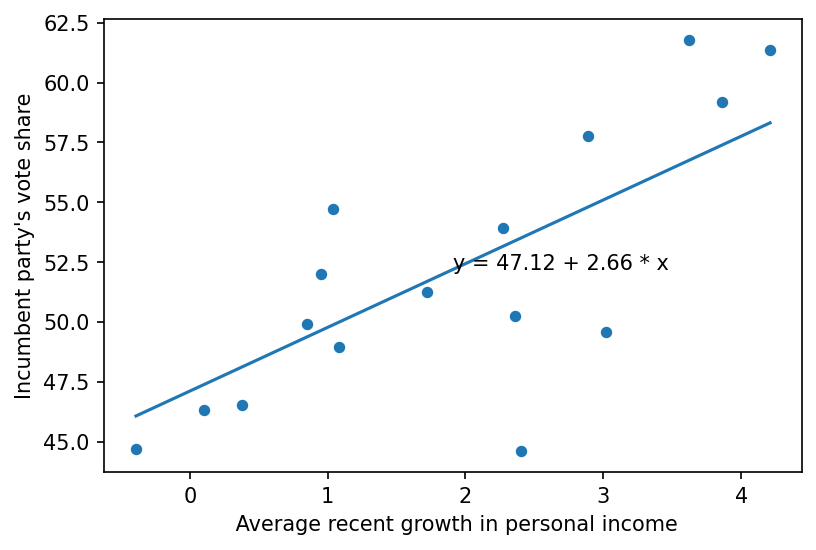

In [184]:
# TODO: Change the plot from points to years
fig, ax = plt.subplots()

a_hat = coefs.loc["Intercept[0]", "Median"]
b_hat = coefs.loc["growth[0]", "Median"]

# Generate x range
growth_domain = np.linspace(hibbs["growth"].min(), hibbs["growth"].max(), 100)

# Plot Line
ax.plot(growth_domain, a_hat+b_hat*growth_domain)

# Add formula
growth_midpoint = growth_domain.mean()
ax.text(growth_midpoint, a_hat+b_hat*growth_midpoint,
       f"y = {np.round(a_hat, 2)} + {np.round(b_hat, 2)} * x");


# Add scatter plot
hibbs.plot(kind="scatter", x="growth", y="vote", ax=ax)
ax.set_xlabel(" Average recent growth in personal income")
ax.set_ylabel("Incumbent party's vote share");

### Plot prediction given 2% growth

In [185]:
# TODO

## Illustrate computations

In [187]:
# In Bambi the results are returned as InferenceData objects
# which are already in an easily selectable format
M1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
a = M1.posterior["Intercept"].values.flatten()
b = M1.posterior["growth"].values.flatten()
sigma = M1.posterior["vote_sd"].values.flatten()

# Since bambi can run multiple chains and draws the number of simulations
# is chains* draws
n_sims = M1.posterior.coords["chain"].shape[0] * M1.posterior.coords["draw"].shape[0]

### Median 

In [15]:
M1.posterior.median()

<xarray.Dataset>
Dimensions:    ()
Data variables:
    Intercept  float64 47.15
    growth     float64 2.627
    vote_sd    float64 3.986

### Mean Absolute Deviation (MAD_SD) 
TODO: Right now is standard deviation. Need to change it to MAD

In [16]:
M1.posterior.std()

<xarray.Dataset>
Dimensions:    ()
Data variables:
    Intercept  float64 1.651
    growth     float64 0.7064
    vote_sd    float64 0.6843

In [17]:

a = M1.posterior["Intercept"].values.flatten()
b = M1.posterior["growth"].values.flatten()
z = a/b
np.median(z)

17.920849041379878

In [18]:
stats.median_abs_deviation(z)

3.441244953503176

### Point prediction given 2% growth

TODO: Verify this is true
Bambi does not have a way to make predictions given a data frame of independent variables

### Alternative way to compute the point prediction

In [19]:
new = 2.0
a_hat = coefs.loc["Intercept[0]", "Median"]
b_hat = coefs.loc["growth[0]", "Median"]
y_point_pred = a_hat + b_hat*new
y_point_pred

52.41

### Uncertainty in prediction given 2% growth

TODO: Verify this is true
Bambi does not have a way to make predictions given a data frame of independent variables

### Do same computation “manually”

In [20]:
a = M1.posterior["Intercept"].values.flatten()
b = M1.posterior["growth"].values.flatten()
y_linpred = a + b*new
y_linpred

array([52.04866043, 53.22665442, 52.58371846, ..., 52.04209219,
       53.06302128, 52.24581597])

### Predictive uncertainty
With a PyMC3 backend we can use the posterior predictive method to do this

TODO: Verify this is true
Bambi does not have a way to make posterior predictive given a data frame of independent variables


### Predictive uncertainty manually

In [21]:
sigma = M1.posterior["vote_sd"].values.flatten()
n_sims = sigma.shape
y_pred = a+b*new + stats.norm(0, sigma).rvs(n_sims)

#### Summarize Predictions

In [22]:
Median = np.median(y_pred)
MAD_SD = stats.median_abs_deviation(y_pred)
win_prob = (y_pred > 50).mean()
median, MAD_SD, win_prob

(f"Predicted Clinton percentage of 2-party vote: {np.round(Median,1)}"
f" with s.e. {np.round(MAD_SD, 1)}"
f"\nPr (Clinton win) = {np.round(win_prob, 2)}")

NameError: name 'median' is not defined

In [ ]:
az.plot_dist(y_pred, kind="hist");

### Predict for many new values

In [ ]:
# TODO: Figure out if there's a simple way in bambi to set pymc3 style
# Shared value to allow for input vars to be changed afterwards

### Plots

In [ ]:
fig, ax = plt.subplots()

ax.scatter(a, b, s=1, alpha=.5)
ax.set_title("Posterior draws of the regression coefficients a, b ")
ax.set_xlabel("a")
ax.set_ylabel("b");

In [ ]:
# TODO: Change the plot from points to years
fig, ax = plt.subplots()

a_hat = coefs.loc["Intercept[0]", "Median"]
b_hat = coefs.loc["growth[0]", "Median"]

# Generate x range
growth_domain = np.linspace(hibbs["growth"].min(), hibbs["growth"].max(), 100)


# Plot Line
for i in range(100):
    a_i, b_i = a[i], b[i]
    ax.plot(growth_domain, a_i+b_i*growth_domain, c="black",
            linewidth=.5,
            zorder=1)

# Add scatter plot
hibbs.plot(kind="scatter", x="growth", y="vote", ax=ax, zorder=2)
ax.set_xlabel(" Average recent growth in personal income")
ax.set_ylabel("Incumbent party's vote share");

### Add more uncertainty

In [ ]:
x = stats.norm(2.0, 0.3).rvs(n_sims)
sigma = M1.posterior["vote_sd"].values.flatten()
n_sims = sigma.shape
y_pred = a+b*new + stats.norm(0, sigma).rvs(n_sims)

Median = np.median(y_pred)
MAD_SD = stats.median_abs_deviation(y_pred)
win_prob = (y_pred > 50).mean()
median, MAD_SD, win_prob

(f"Predicted Clinton percentage of 2-party vote: {np.round(Median,1)}"
f" with s.e. {np.round(MAD_SD, 1)}"
f" Pr (Clinton win) = {np.round(win_prob, 2)}")

In [ ]:
ax = az.plot_dist(y_pred, kind="hist")
ax.set_xlabel("Clinton share of the two-party vote")
ax.set_ylabel("")
ax.set_title("Bayesian simulations of Hillary Clinton vote share, \nbased on 2% rate of economic growth");

### Bayesian inference and prior information

Combining information from a forecast and a poll. Hypothetical forecast and data.

In [ ]:
theta_hat_prior = 0.524
se_prior = 0.041

n = 400
y = 190
theta_hat_data = y/n
se_data = np.sqrt((y/n)*(1-y/n)/n)

theta_hat_bayes = (theta_hat_prior / se_prior**2 + theta_hat_data / se_data**2) / (1 / se_prior**2 + 1 / se_data**2)

se_bayes = np.sqrt(1/(1/se_prior**2 + 1/se_data**2))

In [ ]:
se_data = .075
print((theta_hat_prior/se_prior**2 + theta_hat_data/se_data**2)/(1/se_prior**2 + 1/se_data**2))